# Collaboration and Competition

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="../Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
env.brain_names

['TennisBrain']

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
states.shape

(2, 24)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
import math
import random
import numpy as np
from collections import deque
import torch
from ddpg_agent import Agent
from matplotlib import pyplot as plt

%matplotlib inline

In [6]:
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

Number of agents: 2
Size of each action: 2


In [11]:
agents = [Agent(state_size=state_size, action_size=action_size, 
                random_seed=2) for _ in range(num_agents)]

### Neural Net Architecture

In [13]:
agents[i].actor_local

Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)

In [8]:
def train_agents(env, agents, num_episodes=300, print_every=10):
    
    scores_deque = deque(maxlen=100)
    scores = []
    for episode in range(num_episodes):
        
        env_info = env.reset(train_mode=True)[brain_name]
        [agent.reset() for agent in agents]
        
        states =  env_info.vector_observations
        agent_scores = np.zeros(num_agents)
        
        while True:
            actions = [agents[i].act(states[i]) for i in range(num_agents)]   # let each agent take action for given env observation
           
            env_info = env.step(actions)[brain_name]           # send all agent action's to the environment
            
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                        # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished
            agent_scores += env_info.rewards                  # update the score (for each agent)
        
            for agent in agents:
                agent.step(states, actions, rewards, next_states, dones)
                
            states = next_states                                # roll over states to next time step
            if np.any(dones):                                 # exit loop if episode finished
                break
        
        scores_deque.append(np.max(agent_scores))
        scores.append(np.max(agent_scores))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode + 1, np.mean(scores_deque)), end="")
        
        if (episode + 1) % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode + 1, np.mean(scores_deque)))
        
        if np.mean(scores_deque) >= 0.5:
            for index, agent in enumerate(agents):
                torch.save(agent.actor_local.state_dict(), f'agent_{index + 1}_checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), f'agent_{index + 1}_checkpoint_critic.pth')
            
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format((episode + 1) - 100, 
                                                                                         np.mean(scores_deque)))
            break
            
    return scores
        

In [9]:
scores = train_agents(env, agents, num_episodes=3000, print_every=100)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.00
Episode 600	Average Score: 0.00
Episode 700	Average Score: 0.01
Episode 800	Average Score: 0.01
Episode 900	Average Score: 0.01
Episode 1000	Average Score: 0.04
Episode 1100	Average Score: 0.03
Episode 1200	Average Score: 0.07
Episode 1300	Average Score: 0.08
Episode 1400	Average Score: 0.11
Episode 1500	Average Score: 0.11
Episode 1600	Average Score: 0.13
Episode 1700	Average Score: 0.28
Episode 1759	Average Score: 0.51
Environment solved in 1659 episodes!	Average Score: 0.51


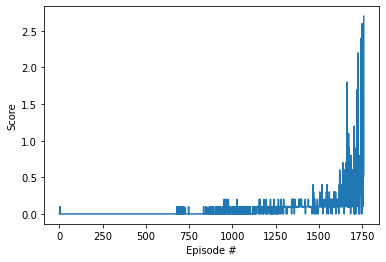

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Watch Trained Agent Playing Tennis 

In [11]:
env_info = env.reset(train_mode=False)[brain_name]                    # reset the environment

agents = [Agent(state_size=state_size, action_size=action_size, 
                random_seed=2) for _ in range(num_agents)]

for i in range(num_agents):
    agents[i].actor_local.load_state_dict(torch.load(f'agent_{i + 1}_checkpoint_actor.pth'))
    agents[i].critic_local.load_state_dict(torch.load(f'agent_{i + 1}_checkpoint_critic.pth'))

scores = np.zeros(num_agents)
while True:                                      
    states = env_info.vector_observations                             # get the current state (for each agent)
    actions = [agents[i].act(states[i], add_noise=False) for i in range(num_agents)]   # select an action (for each agent)
    env_info = env.step(actions)[brain_name]                          # send all actions to tne environment
    rewards = env_info.rewards                                        # get reward (for each agent)
    dones = env_info.local_done                                       # see if episode finished
    scores += env_info.rewards                                        # update the score (for each agent)
    if np.any(dones):                                                 # exit loop if episode finished
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 2.650000039488077


When finished, you can close the environment.

In [12]:
env.close()